In [2]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import roc_auc_score, roc_curve, auc


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from timeit import default_timer as timer


In [3]:
train_data_file = "Brunel_BdJPsiKs_MagU_30k.csv"
data = pd.read_csv(train_data_file)
features = data.drop(["is_true_seed","has_MCParticle",
                      "is_downstream_reconstructible",
                      "has_MCParticle_not_electron",
                     "is_downstream_reconstructible_not_electron",
                     "seed_mva_value"] , axis=1).astype(np.float64)

target = data.is_downstream_reconstructible
features = features.drop(features.columns[0], axis=1)
features.head()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
0,1.447929,1849.101146,1083.522737,27.0,0.0,12.0,-1418.736880,-143.095899,-0.722093,-0.038671
1,0.354945,10085.622823,1345.148537,24.0,0.0,12.0,-393.699553,-284.193871,-0.129122,-0.037920
2,2.906524,2441.534682,1013.888408,24.0,0.0,12.0,-834.004914,-270.235334,-0.456235,-0.015198
3,3.234916,2604.073941,904.097232,24.0,0.0,12.0,-475.119652,-230.380918,-0.369728,-0.018967
4,0.842265,2644.554049,1068.602364,23.0,0.0,12.0,-899.187260,-101.826800,-0.440227,-0.036610


In [4]:
def basic_transforamtion(data):
    #abs transformation
    out = data
    out["abs_seed_x"]=np.abs(data['seed_x'])
    out["abs_seed_y"]=np.abs(data['seed_y'])
    out["abs_seed_tx"]=np.abs(data['seed_tx'])
    out["abs_seed_ty"]=np.abs(data['seed_ty'])
    out['seed_r'] = np.sqrt(np.square(data.seed_x) +np.square(data.seed_y))    
    out['pseudo_rapidity'] = np.arctanh(data.seed_pt/data.seed_p)
    return out

In [5]:
features = basic_transforamtion(features)

In [6]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [7]:
X_train, X_valid, Y_train, Y_valid = train_test_split(features, target, test_size=0.2, random_state=12)

In [8]:
X_valid = (X_valid - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

In [9]:
datasets={
    "train":TensorDataset(torch.Tensor(np.array(X_train.values)).to(device), torch.Tensor(np.array(Y_train.values, dtype=np.uint8)).to(device)),
    "valid":TensorDataset(torch.Tensor(np.array(X_valid.values)).to(device), torch.Tensor(np.array(Y_valid.values, dtype=np.uint8)).to(device))
}


In [10]:
datasets["valid"].__getitem__(0)

(tensor([ 1.3830, -0.0121, -0.0142,  0.2311, -0.5876, -1.2248,  0.7084, -2.9106,
         -1.5882, -2.1764, -0.0873,  3.0382,  1.2874,  2.0683,  1.7239,  1.3785],
        device='cuda:1'), tensor(0., device='cuda:1'))

In [11]:
dataloaders = { 
    'train':DataLoader(datasets["train"], 
                   batch_size=128,
                   shuffle=True,
                    num_workers=0),
    'valid':DataLoader(datasets["valid"],
                      batch_size=128,
                      shuffle=False,
                      num_workers=0)
}

In [12]:
for batch in dataloaders["train"]:
    print("features", batch[0], len(batch[0]))
    print("target", batch[1], len(batch[1]))
    break

features tensor([[-0.8635, -0.0062, -0.0090,  ..., -0.7208, -0.8892, -0.7590],
        [-0.4365,  0.0055,  0.0544,  ...,  1.7633,  1.0530, -0.3052],
        [-0.2292, -0.0008, -0.0096,  ..., -0.8266, -1.1416, -1.0028],
        ...,
        [-0.6779, -0.0095,  0.0023,  ...,  1.0996,  1.5998,  0.5111],
        [ 0.2980, -0.0098, -0.0002,  ...,  3.0851,  1.4408,  0.4850],
        [ 1.3398, -0.0118, -0.0104,  ...,  1.3279,  0.9753,  1.4334]],
       device='cuda:1') 128
target tensor([0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0.,
        0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1.,
        0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
        0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1.,
        0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1.,
        0., 0., 0., 1., 0., 1., 0., 0., 1.

In [13]:
def train_and_valid_classification(model,
                                   criterion,
                                   optimizer,
                                   run_hist={},
                                   num_epochs=10,
                                   save_every_nth_batch_loss=50):
    """Train and evaluate the classification model."""
    if len(run_hist) == 0:
        run_hist = {key: [] for key in ['epoch_loss_train',
                                    'epoch_loss_valid',
                                    'epoch_acc_valid',
                                    'epoch_acc_train',   
                                    'batch_loss_train']}
    process_timer = timer()
    
    for epoch in range(num_epochs):
        print('\nEpoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'valid']:
            start_epoch = timer()
            if phase == 'train':
                model.train()
            else:
                model.eval()
        
            running_loss = 0.0
            running_corrects = 0
        
            for i, batch in enumerate(dataloaders[phase]):
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels.long())

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data.long())

                if phase == 'train' and i % save_every_nth_batch_loss == 0:
                    run_hist['batch_loss_train'].append(loss.item())

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.float() / len(datasets[phase])

            print('{} loss: {:.4f}, {} acc: {:.4f}, elapsed:{:.4f}'.\
            format(phase,
                   epoch_loss.item(),
                   phase,
                   epoch_acc.item(),
                   timer()-start_epoch
                 ))
                 
        
            run_hist['epoch_loss_' + phase].append(epoch_loss.item())
            run_hist['epoch_acc_' + phase].append(epoch_acc.item())

    print("training took: ",timer()- process_timer)    
    return model, run_hist

# Build the shallow model

In [14]:
class NHiddenTrackingNetwork(torch.nn.Module):
    def __init__(self, inputs,n_hidden, hidden_dict):
        super(NHiddenTrackingNetwork, self).__init__()
        if n_hidden < 3: 
          raise ValueError("n_hidden must be greater than 2")
        self.input_layer = nn.Linear(inputs, hidden_dict[0])
        self.layers = nn.ModuleList()
        for layer_it in range(n_hidden-1):
          self.layers.append(nn.Linear(hidden_dict[layer_it],
                                       hidden_dict[layer_it+1]))
        self.output_layer = nn.Linear(hidden_dict[n_hidden-1], 2)
        self.dropout = nn.Dropout(p=0.5)
        self.inputs = inputs
    
    def forward(self, x):
        x = self.input_layer(x)
        x = F.relu(x)
        x=self.dropout(x)
        for layer in self.layers:
          x = layer(x)
          x = F.relu(x)
          x = self.dropout(x)
        x = self.output_layer(x)
        return x

In [15]:
n_hidden = {0:40,
            1:30,
           2:20,
           3:10,
           4:10}

model = NHiddenTrackingNetwork(X_train.shape[1], 5, n_hidden).to(device)
model

NHiddenTrackingNetwork(
  (input_layer): Linear(in_features=16, out_features=40, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=40, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=10, bias=True)
  )
  (output_layer): Linear(in_features=10, out_features=2, bias=True)
  (dropout): Dropout(p=0.5)
)

In [16]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


Model's state_dict:
input_layer.weight 	 torch.Size([40, 16])
input_layer.bias 	 torch.Size([40])
layers.0.weight 	 torch.Size([30, 40])
layers.0.bias 	 torch.Size([30])
layers.1.weight 	 torch.Size([20, 30])
layers.1.bias 	 torch.Size([20])
layers.2.weight 	 torch.Size([10, 20])
layers.2.bias 	 torch.Size([10])
layers.3.weight 	 torch.Size([10, 10])
layers.3.bias 	 torch.Size([10])
output_layer.weight 	 torch.Size([2, 10])
output_layer.bias 	 torch.Size([2])


In [17]:
criterion = nn.CrossEntropyLoss().cuda()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer, num_epochs=50)


Epoch 1/50
----------
train loss: 0.6139, train acc: 0.6923, elapsed:94.4833
valid loss: 0.5112, valid acc: 0.7807, elapsed:8.6935

Epoch 2/50
----------
train loss: 0.5552, train acc: 0.7556, elapsed:68.4452
valid loss: 0.4828, valid acc: 0.7938, elapsed:8.7273

Epoch 3/50
----------
train loss: 0.5397, train acc: 0.7657, elapsed:68.1066
valid loss: 0.4726, valid acc: 0.8000, elapsed:8.7397

Epoch 4/50
----------
train loss: 0.5322, train acc: 0.7713, elapsed:68.1758
valid loss: 0.4673, valid acc: 0.8042, elapsed:8.7798

Epoch 5/50
----------
train loss: 0.5283, train acc: 0.7733, elapsed:68.0315
valid loss: 0.4584, valid acc: 0.8061, elapsed:8.7204

Epoch 6/50
----------
train loss: 0.5233, train acc: 0.7744, elapsed:68.0403
valid loss: 0.4467, valid acc: 0.8072, elapsed:8.7130

Epoch 7/50
----------
train loss: 0.5126, train acc: 0.7811, elapsed:67.8643
valid loss: 0.4111, valid acc: 0.8447, elapsed:8.7101

Epoch 8/50
----------
train loss: 0.4973, train acc: 0.7968, elapsed:68.101

In [19]:
torch.save(model.state_dict(), "5NN_dropout.pt")

In [20]:
def plot_training_classification(run_hist):
    """Plot the training history of the classification model."""
    fig, ax = plt.subplots(1,2, figsize=(20,6), sharex=True)
    x = np.arange(len(run_hist["epoch_loss_train"])) + 1
    ax[0].plot(x, run_hist["epoch_loss_train"],'b', marker='.', label="train loss")
    ax[0].plot(x, run_hist["epoch_loss_valid"],'r', marker='.', label="valid loss")
    ax[0].legend()
    ax[1].plot(x, run_hist["epoch_acc_train"],'b', marker='.', label="train accuracy")
    ax[1].plot(x, run_hist["epoch_acc_valid"],'r', marker='.', label="valid accuracy")
    ax[1].legend()


In [21]:
def print_roc(model, X, Y):
    X = torch.tensor(X.values, dtype=torch.float).to(device)
    output =  model(X)    
    plt.figure(figsize=[6, 6])
    fpr, tpr, thresholds = roc_curve(Y, output.cpu().detach().numpy()[:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()



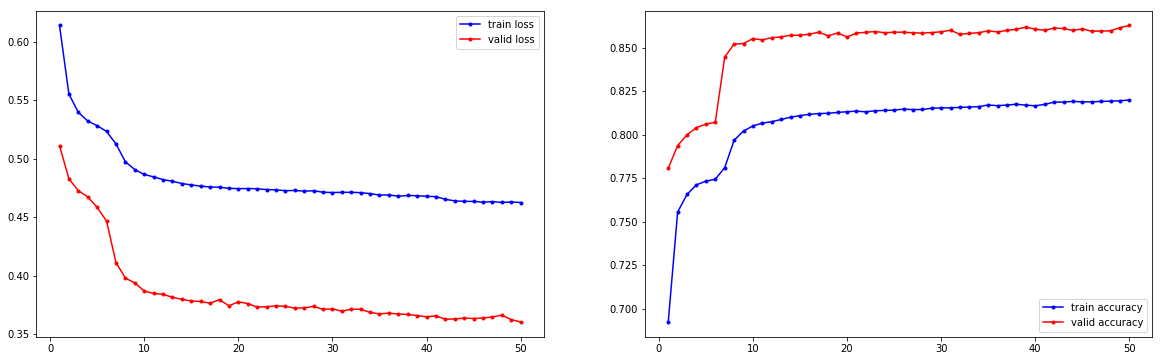

In [22]:
plot_training_classification(run_hist)

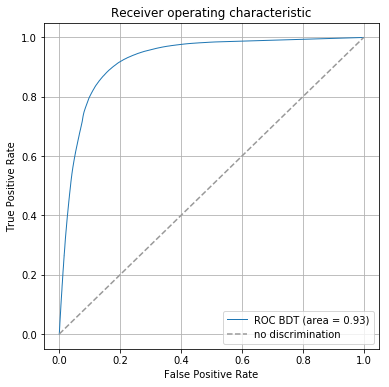

In [23]:
print_roc(model,X_valid, Y_valid )

In [31]:
F

<module 'torch.nn.functional' from '/anaconda/envs/py36/lib/python3.6/site-packages/torch/nn/functional.py'>

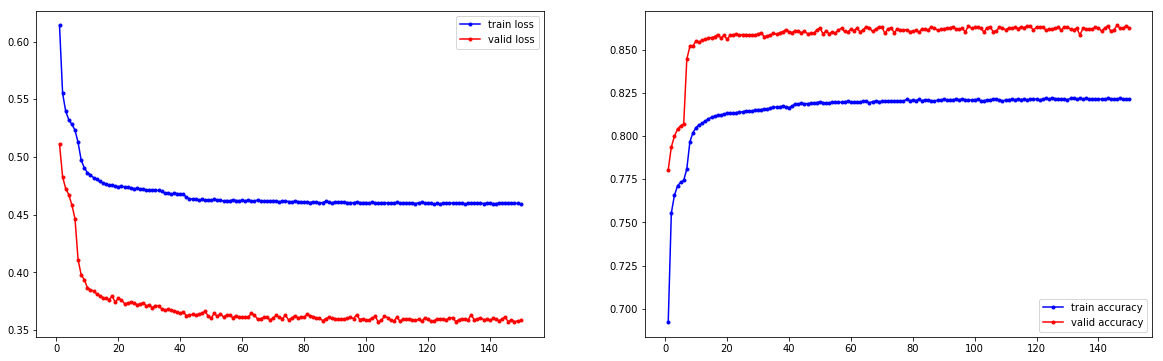

In [25]:
plot_training_classification(run_hist)

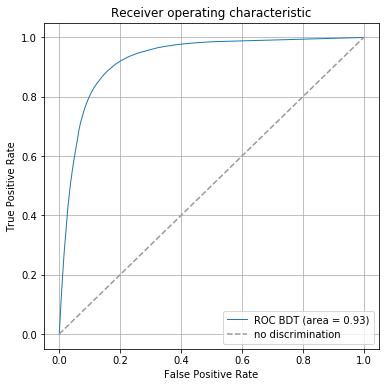

In [26]:
print_roc(model,X_valid, Y_valid )

In [27]:
for param in model.named_parameters():
  print(param)


('input_layer.weight', Parameter containing:
tensor([[ 4.3514e-03,  8.8183e-02,  4.5466e-01,  7.9420e-04,  7.1837e-03,
         -4.2999e-03, -6.4258e-03,  3.3039e-02,  1.3944e-02, -5.7815e-03,
          5.1345e-01,  6.6708e-02, -2.1445e-01, -1.0619e-01,  1.9075e-01,
         -4.5802e-01],
        [-4.5825e-02, -3.9849e+00,  1.4537e+00,  3.1303e-02, -2.4108e-01,
          1.6046e-02,  5.5843e-04,  4.1704e-04,  1.9347e-03,  2.9180e-03,
         -2.2427e-02, -5.6036e-02,  2.4428e-01,  7.1216e-02,  2.4841e-02,
         -2.7332e-01],
        [-1.5746e-02, -1.3847e+00, -2.7204e-01, -2.5847e-03, -2.4118e-02,
          2.4185e-02,  3.4889e-02, -2.5829e-03, -2.6737e-02, -1.6992e-02,
         -3.9110e-01,  2.3100e-01,  3.0418e-01, -1.8838e-01, -3.3338e-01,
          3.0001e-01],
        [ 2.0872e-02,  1.7630e+00,  1.8472e+00, -5.9072e-02, -4.3968e-02,
         -2.9220e-03,  2.4480e-01,  4.0963e-03, -4.5597e-01, -9.3711e-03,
          1.7581e-02, -2.6170e-01,  3.0130e-02,  2.4633e-01,  6.8279e-02

In [28]:
trenable_parameters = filter(lambda p: p.requires_grad, model.parameters())
print("n_params", sum([np.prod(p.size()) for p in trenable_parameters]) )

n_params 2872


In [29]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'run_history':run_hist,
            }, ".5NN_dropout_2.pt")


In [30]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer,run_hist, num_epochs=50)


Epoch 1/50
----------
train loss: 0.4597, train acc: 0.8220, elapsed:184.4782
valid loss: 0.3589, valid acc: 0.8628, elapsed:27.6327

Epoch 2/50
----------
train loss: 0.4596, train acc: 0.8216, elapsed:184.5927
valid loss: 0.3567, valid acc: 0.8642, elapsed:28.1355

Epoch 3/50
----------
train loss: 0.4598, train acc: 0.8215, elapsed:184.0474
valid loss: 0.3583, valid acc: 0.8627, elapsed:28.5404

Epoch 4/50
----------
train loss: 0.4599, train acc: 0.8214, elapsed:183.9130
valid loss: 0.3582, valid acc: 0.8621, elapsed:28.6136

Epoch 5/50
----------
train loss: 0.4598, train acc: 0.8218, elapsed:184.5239
valid loss: 0.3581, valid acc: 0.8632, elapsed:27.8166

Epoch 6/50
----------
train loss: 0.4593, train acc: 0.8218, elapsed:150.4321
valid loss: 0.3578, valid acc: 0.8634, elapsed:8.5523

Epoch 7/50
----------
train loss: 0.4600, train acc: 0.8217, elapsed:65.8060
valid loss: 0.3583, valid acc: 0.8625, elapsed:8.5435

Epoch 8/50
----------
train loss: 0.4590, train acc: 0.8215, ela

In [ ]:
plot_training_classification(run_hist)